# Install libraries

In [ ]:
# !nvidia-smi

In [ ]:
!pip install torch torchvision torchmetrics pytorch-lightning

# Import libraries

In [1]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.swa_utils import AveragedModel, update_bn

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

from torchmetrics import MeanMetric

from IPython.display import display, HTML, clear_output

# Helper functions

In [2]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_num_parameter(model):
    # Count the number of parameters
    num_params = sum(p.numel() for p in model.parameters())
    return num_params

def save_images(images, path, **kwargs):
    grid = make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to("cpu").numpy()
    im = Image.fromarray(ndarr)
    im.save(path)
    
def get(element: torch.Tensor, t: torch.Tensor):
    """
    Get value at index position "t" in "element" and
        reshape it to have the same dimension as a batch of images.
    """
    ele = element.gather(-1, t)
    return ele.reshape(-1, 1, 1, 1)

def setup_log_directory(config):
    '''Log and Model checkpoint directory Setup'''
    
    if os.path.isdir(config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = config.log_dir

    # Update the training config default directory 
    log_dir        = os.path.join(config.root_log_dir,        version_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(log_dir,        exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")
    print(f"Model Checkpoint at: {checkpoint_dir}")
    
    return log_dir, checkpoint_dir

def frames2vid(images, save_path):

    WIDTH = images[0].shape[1]
    HEIGHT = images[0].shape[0]

#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     fourcc = 0
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(save_path, fourcc, 25, (WIDTH, HEIGHT))

    # Appending the images to the video one by one
    for image in images:
        video.write(image)

    # Deallocating memories taken for window creation
    # cv2.destroyAllWindows()
    video.release()
    return

def display_gif(gif_path):
    b64 = base64.b64encode(open(gif_path, 'rb').read()).decode('ascii')
    display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

def display_image(image):
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Configurations

In [27]:
from dataclasses import dataclass

@dataclass
class BaseConfig:
    DEVICE = get_default_device()
    DATASET = "Anime-face-128"  #  "MNIST", "Cifar-10", "Cifar-100", "Flowers", "Animal-10", "Animal-90", "Anime-face", "Anime-face-128"
    IMG_SIZE = 64
 
    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "checkpoints")
 
    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"
 
 
@dataclass
class TrainingConfig:
    TIMESTEPS = 1000  # Define number of diffusion timesteps
    IMG_SHAPE = (1, BaseConfig.IMG_SIZE, BaseConfig.IMG_SIZE) if BaseConfig.DATASET == "MNIST" else (3, BaseConfig.IMG_SIZE, BaseConfig.IMG_SIZE)
    NUM_EPOCHS = 800
    TRAINING_SAMPLES = 1.5e6
    BATCH_SIZE = 32
    LR = 2e-4
    NUM_WORKERS = 2

In [4]:
# 32x32
# @dataclass
# class ModelConfig:
#     BASE_CH = 64  # 64, 128, 256, 256
#     BASE_CH_MULT = (1, 2, 4, 4) # 32, 16, 8, 4
#     APPLY_ATTENTION = (False, True, True, False)
#     DROPOUT_RATE = 0.1
#     TIME_EMB_MULT = 4 # 128

# 64x64
# @dataclass
# class ModelConfig:
#     BASE_CH = 128  # 128, 256, 256, 512
#     BASE_CH_MULT = (1, 2, 2, 4) # 64, 32, 16, 8
#     APPLY_ATTENTION = (False, False, True, True)
#     DROPOUT_RATE = 0.1
#     TIME_EMB_MULT = 4 # 128

# 128x128
@dataclass
class ModelConfig:
    BASE_CH = 128  # 128, 256, 256, 512, 512
    BASE_CH_MULT = (1, 2, 2, 4, 4) # 128, 64, 32, 16, 8
    APPLY_ATTENTION = (False, False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 4 # 128

# 256x256
# @dataclass
# class ModelConfig:
#     BASE_CH = 128  # 128, 256, 256, 512, 512, 512
#     BASE_CH_MULT = (1, 2, 2, 4, 4, 4) # 256, 128, 64, 32, 16, 
#     APPLY_ATTENTION = (False, False, False, False, True, False)
#     DROPOUT_RATE = 0.1
#     TIME_EMB_MULT = 4 # 128

# UNet Model

In [5]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)

class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h

class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)
        
        return h

class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)

class UpSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding="same")
        )

    def forward(self, x, *args):
        return self.upsample(x)

class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=128,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=4,
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)
                
                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t):
        time_emb = self.time_embeddings(t)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h

# Data Loader

In [6]:
def get_dataset(dataset_name='MNIST'):
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((BaseConfig.IMG_SIZE, BaseConfig.IMG_SIZE), 
                                          interpolation=torchvision.transforms.InterpolationMode.BICUBIC, 
                                          antialias=True),
            torchvision.transforms.RandomHorizontalFlip(),
#             torchvision.transforms.Normalize(MEAN, STD),
            torchvision.transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
        ]
    )
     
    if dataset_name.upper() == "MNIST":
        dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-10":    
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-100":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Flowers":
        dataset = datasets.ImageFolder(root="/kaggle/input/flowers-recognition/flowers", transform=transforms)
    elif dataset_name == "Animal-10":
        dataset = datasets.ImageFolder(root="/kaggle/input/animals10/raw-img", transform=transforms)
    elif dataset_name == "Animal-90":
        dataset = datasets.ImageFolder(root="/kaggle/input/animal-image-dataset-90-different-animals/animals/animals", transform=transforms)
    elif dataset_name == "Anime-face":
        dataset = datasets.ImageFolder(root="/kaggle/input/animefacedataset", transform=transforms)
    elif dataset_name == "Anime-face-128":
        dataset = datasets.ImageFolder(root="/kaggle/input/anime-faces-dataset", transform=transforms)
    
    else:
        raise Exception("Upsupported dataset")
    return dataset

def inverse_transform(tensors):
    """Convert tensors from [-1, 1] to [0, 255]"""
    return ((tensors.clip(-1, 1) + 1.0) / 2.0) * 255.0

In [7]:
def get_dataloader(
    dataset_name="MNIST",
    batch_size=32,
    pin_memory=False,
    shuffle=True,
    num_workers=0,
    device="cpu"
):
    dataset = get_dataset(dataset_name)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                           pin_memory=pin_memory,
                           num_workers=num_workers,
                           shuffle=shuffle)
    
#     dataloader = DeviceDataLoader(dataloader, device=device)
    return dataloader

# Visualize dataset

In [8]:
loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device='cpu'
)

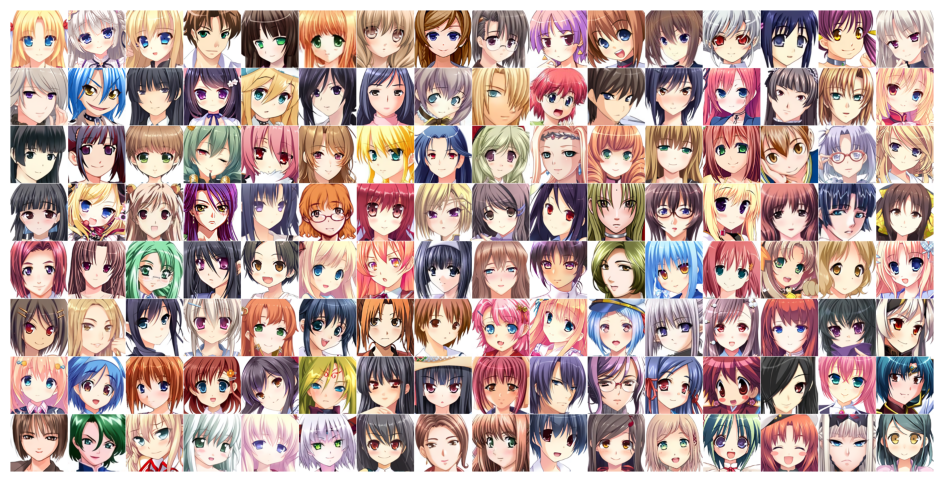

In [9]:
plt.figure(figsize=(12, 6), facecolor='white')

for b_image, _ in loader:
    b_image = inverse_transform(b_image)
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    break

# Diffusion Process

In [10]:
class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()

    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta
        
        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)
         
    def get_betas(self):
        """linear schedule, proposed in original ddpm paper"""
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )
        
def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)  # Noise
    mean    = get(sd.sqrt_alpha_cumulative, t=timesteps) * x0  # Image scaled
    std_dev = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) # Noise scaled
    sample  = mean + std_dev * eps # scaled inputs * scaled noise

    return sample, eps  # return ... , gt noise --> model predicts this)

## Forward Diffusion

In [11]:
sd = SimpleDiffusion(
    num_diffusion_timesteps=TrainingConfig.TIMESTEPS,
    device="cpu"
)
loader = iter(
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device='cpu'
    )
)

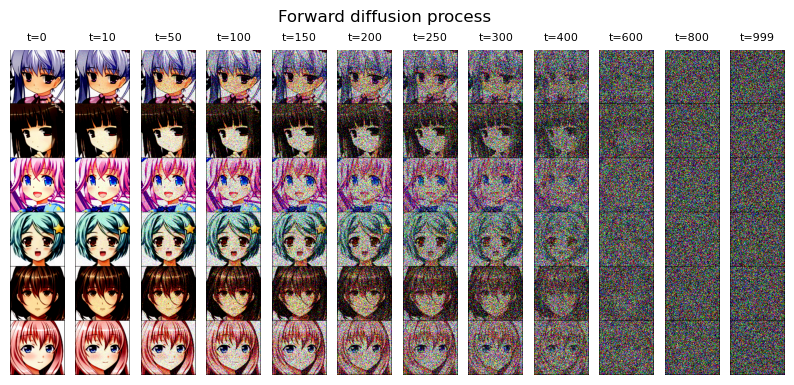

In [12]:
x0s, _ = next(loader)

noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)
    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts = make_grid(xts, nrow=1, padding=1)
    
    noisy_images.append(xts)

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f't={timestep}',fontsize=8)
    ax[i].axis('off')
    ax[i].grid(False)

plt.suptitle("Forward diffusion process", y=0.9)
plt.axis('off')
plt.show()

# Training

## Initialize and confiuration

In [13]:
dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pin_memory    = True,
    num_workers   = TrainingConfig.NUM_WORKERS,
)
valid_dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = 1,
    device        = BaseConfig.DEVICE,
    pin_memory    = False,
    shuffle       = False,
    num_workers   = 1,
)

total_epochs = int(math.ceil(TrainingConfig.TRAINING_SAMPLES / len(dataloader) / TrainingConfig.BATCH_SIZE))
total_epochs = min(TrainingConfig.NUM_EPOCHS, total_epochs)

sample_epoch = int(max(5, total_epochs // 20))
print(total_epochs, sample_epoch)

log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())
generate_video = False
ext = ".mp4" if generate_video else ".png"

25 5
Logging at: Logs_Checkpoints/Inference/version_17
Model Checkpoint at: Logs_Checkpoints/checkpoints/version_17


## Algorithm implementation

![Algorithm1](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models_DDPM_trainig_inference_algorithm-1024x247.png)

In [14]:
# Algorithm 1: Training
def train_one_epoch(model, sd, loader, optimizer, scaler, loss_fn, epoch=800, total_epochs=total_epochs,
                   base_config=BaseConfig(), training_config=TrainingConfig()):
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{total_epochs}")
         
        for x0s, _ in loader:
            tq.update(1)
            
            ts = torch.randint(low=1, high=training_config.TIMESTEPS, size=(x0s.shape[0],), device=base_config.DEVICE)
            xts, gt_noise = forward_diffusion(sd, x0s, ts)

            with amp.autocast():
                pred_noise = model(xts, ts)
                print(xts.shape, pred_noise.shape)
                loss = loss_fn(gt_noise, pred_noise)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss

In [15]:
# Algorithm 2: Sampling

@torch.no_grad()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, nrow=8, device="cpu", **kwargs):

    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()

    if kwargs.get("generate_video", False):
        outs = []

    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        predicted_noise = model(x, ts)

        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 

        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )

        if kwargs.get("generate_video", False):
            x_inv = inverse_transform(x).type(torch.uint8)
            grid = make_grid(x_inv, nrow=nrow, pad_value=255.0).to("cpu")
            ndarr = torch.permute(grid, (1, 2, 0)).numpy()[:, :, ::-1]
            outs.append(ndarr)

    if kwargs.get("generate_video", False): # Generate and save video of the entire reverse process. 
        frames2vid(outs, kwargs['save_path'])
        display(Image.fromarray(outs[-1][:, :, ::-1])) # Display the image at the final timestep of the reverse process.
        return None

    else: # Display and save the image at the final timestep of the reverse process. 
        x = inverse_transform(x).type(torch.uint8)
        grid = make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
        pil_image = TF.functional.to_pil_image(grid)
        pil_image.save(kwargs['save_path'], format=kwargs['save_path'].split(".")[-1].upper())
        display_image(grid.permute(1, 2, 0))
        return None

## Training

### Vanilla

In [16]:
# model = UNet(
#     input_channels          = TrainingConfig.IMG_SHAPE[0],
#     output_channels         = TrainingConfig.IMG_SHAPE[0],
#     base_channels           = ModelConfig.BASE_CH,
#     base_channels_multiples = ModelConfig.BASE_CH_MULT,
#     apply_attention         = ModelConfig.APPLY_ATTENTION,
#     dropout_rate            = ModelConfig.DROPOUT_RATE,
#     time_multiple           = ModelConfig.TIME_EMB_MULT,
# )
# model.to(BaseConfig.DEVICE)
# dataloader = DeviceDataLoader(dataloader, device=BaseConfig.DEVICE)

# optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)

# loss_fn = nn.MSELoss()

# sd = SimpleDiffusion(
#     num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
#     img_shape               = TrainingConfig.IMG_SHAPE,
#     device                  = BaseConfig.DEVICE,
# )

# scaler = amp.GradScaler()

In [17]:
# for epoch in range(1, total_epochs):
#     torch.cuda.empty_cache()
#     gc.collect()
    
#     # Algorithm 1: Training
#     train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)

#     if epoch % sample_epoch == 0:
#         save_path = os.path.join(log_dir, f"{epoch}{ext}")
        
#         # Algorithm 2: Sampling
#         reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, num_images=32, generate_video=generate_video,
#             save_path=save_path, img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE,
#         )

#         # clear_output()
#         checkpoint_dict = {
#             "opt": optimizer.state_dict(),
#             "scaler": scaler.state_dict(),
#             "model": model.state_dict()
#         }
#         torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "model.ckpt"))
#         del checkpoint_dict

### Using Pytorch Lightning

In [28]:
# Pytorch Lightning

class LitUNet(LightningModule):
    def __init__(self, base_config=BaseConfig(), training_config=TrainingConfig(), model_config=ModelConfig()):
        super().__init__()

        self.save_hyperparameters()
        self.model = UNet(
            input_channels          = training_config.IMG_SHAPE[0],
            output_channels         = training_config.IMG_SHAPE[0],
            base_channels           = model_config.BASE_CH,
            base_channels_multiples = model_config.BASE_CH_MULT,
            apply_attention         = model_config.APPLY_ATTENTION,
            dropout_rate            = model_config.DROPOUT_RATE,
            time_multiple           = model_config.TIME_EMB_MULT,
        )
        self.sd = SimpleDiffusion(
            num_diffusion_timesteps = training_config.TIMESTEPS,
            img_shape               = training_config.IMG_SHAPE,
            device                  = base_config.DEVICE,
        )
        self.loss_fn = nn.MSELoss()
        self.log_dir = log_dir
        self.generate_video = False
        self.ext = ".mp4" if self.generate_video else ".png"

    def training_step(self, batch, batch_idx):
        x0s, _ = batch
        ts = torch.randint(low=1, high=self.hparams.training_config.TIMESTEPS, size=(x0s.shape[0],), device=self.device)
        xts, gt_noise = forward_diffusion(self.sd, x0s, ts)

        pred_noise = self.model(xts, ts)
        loss = self.loss_fn(gt_noise, pred_noise)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        if self.current_epoch > 0:
            save_path = os.path.join(self.log_dir, f"{self.current_epoch}{self.ext}")

            # Algorithm 2: Sampling
            reverse_diffusion(
                self.model, self.sd, timesteps=self.hparams.training_config.TIMESTEPS, num_images=32, generate_video=self.generate_video,
                save_path=save_path, img_shape=self.hparams.training_config.IMG_SHAPE, device=self.device,
            )

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=TrainingConfig.LR)
        return {"optimizer": optimizer}

In [29]:
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir, save_last=True, verbose=True)
model = LitUNet()
trainer = Trainer(
    default_root_dir=log_dir,
    max_epochs=total_epochs,
    limit_val_batches=1,
    check_val_every_n_epoch=sample_epoch,
    accelerator="auto",
    devices="auto",  # limiting got iPython runs
    callbacks=[checkpoint_callback],
    log_every_n_steps=20
)

In [30]:
print("Num parameters:", get_num_parameter(model.model))

Num parameters: 111157507


In [31]:
trainer.fit(model, dataloader, valid_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 14.86 GiB already allocated; 21.75 MiB free; 14.89 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
checkpoint_callback.last_model_path

# Inference

In [ ]:
IMG_EXTENSIONS = set(['png', 'jpg', 'jpeg'])
VIDEO_EXTENSIONS = set(['mp4', 'gif'])

def generate(model, num_images=128, timesteps=1000, nrow=16, format='png'):
    if format in IMG_EXTENSIONS:
        generate_video = False
    elif format in VIDEO_EXTENSIONS:
        generate_video = True
    else:
        print('Unsupported format')
        return

    filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}.{format}"

    save_path = os.path.join(log_dir, filename)
    reverse_diffusion(
        model,
        sd,
        num_images=num_images,
        generate_video=generate_video,
        save_path=save_path,
        timesteps=timesteps,
        img_shape=TrainingConfig.IMG_SHAPE,
        device=BaseConfig.DEVICE,
        nrow=nrow,
    )
    print(save_path)

In [ ]:
# model = UNet(
#     input_channels          = TrainingConfig.IMG_SHAPE[0],
#     output_channels         = TrainingConfig.IMG_SHAPE[0],
#     base_channels           = ModelConfig.BASE_CH,
#     base_channels_multiples = ModelConfig.BASE_CH_MULT,
#     apply_attention         = ModelConfig.APPLY_ATTENTION,
#     dropout_rate            = ModelConfig.DROPOUT_RATE,
#     time_multiple           = ModelConfig.TIME_EMB_MULT,
# )
# model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ckpt.tar"), map_location='cpu')['model'])

checkpoint_path = checkpoint_callback.last_model_path
model = LitUNet.load_from_checkpoint(checkpoint_path).model
model.to(BaseConfig.DEVICE)

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

In [ ]:
generate(model, format='png')

In [ ]:
generate(model, format='png')

In [ ]:
generate(model, format='png')

In [ ]:
# generate(model, format='mp4')

# References

1. [An In-Depth Guide to Denoising Diffusion Probabilistic Models – From Theory to Implementation](https://learnopencv.com/denoising-diffusion-probabilistic-models/#modified-forward-diffusion-kernel)
2. [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)